<a href="https://colab.research.google.com/github/Tatianabeg/-/blob/main/DZ_%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B1%D0%B5%D0%B7_%D1%83%D1%87%D0%B8%D1%82%D0%B5%D0%BB%D1%8F_%D0%B2_Scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение без учителя в Scikit-learn


В отличие от обучения с учителем, в задачах обучения без учителя эти правильные ответы отсутствуют. В таком случае нам уже не нужно предсказывать какую-то величину, а лишь понять, как связаны между собой объекты из нашей выборки.

## Кластеризация

Одним из самых часто применяемых методов обучения без учителя является _кластеризация_. Задача кластеризации -  разбить объекты из выборки на определённое число групп (или _кластеров_) так, чтобы "похожие" объекты попали в один кластер.

Здесь мы познакомимся с одним из наиболее известных алгоритмов кластеризации - _k-means_ или _k средних_.

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=100)

Данная модель принимает на вход параметр `n_clusters`, т.е. число кластеров, на которые мы хотели бы разбить наши данные.

На начальной итерации алгоритм произвольным образом выбирает центры кластеров - _центроиды_ (столько, сколько мы задали в параметре `n_clusters`). Затем повторяется следующий процесс:

1. Отнести каждый объект из выборки к тому кластеру, чей центр ближе всего к этому объекту.
2. Переставить центроид каждого кластера в центр этого кластера (с учётом новых объектов).

Этот процесс повторяется до тех пор, пока координаты центров не перестанут изменяться.

Разберёмся с этим алгоритмом на практике. Для этого воспользуемся готовой функцией для создания датасета.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [ ]:
def make_data(n, seed):
    np.random.seed(seed)

    shift_matrix = np.array([[3, 3],
                             [6, 9],
                             [9, 3]])

    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    data = np.swapaxes(data, 1, 2)
    data = data.reshape((-1, 2))
    data *= np.array([[20, 0.5]])

    df = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]},
                      columns=['x', 'y'])
    df = df.sample(frac=1.0)

    return df

Эта функция принимает на вход параметры `n` (число объектов в каждой группе объектов) и `seed` (зерно, необходимое для воспроизводимости случайных значений). В результате получается `DataFrame`, содержащий заданное число объектов в каждой группе (всего 3 группы) с двумя признаками: `'x'` и `'y'`.

Получим с помощью этой функции два набора данных.

In [ ]:
train = make_data(10, 42)
test = make_data(10, 27)

Чтобы придать данным больший предметный смысл, представим, что полученные нами данные - это данные о разных видах рыб, обитающих в водоёме. Мы бы хотели разбить представителей рыб из этого водоёма на 3 кластера.

Посмотрим, как расположены наши объекты в пространстве. Поскольку у каждого объекта всего два признака, мы можем представить каждый объект как точку на плоскости:

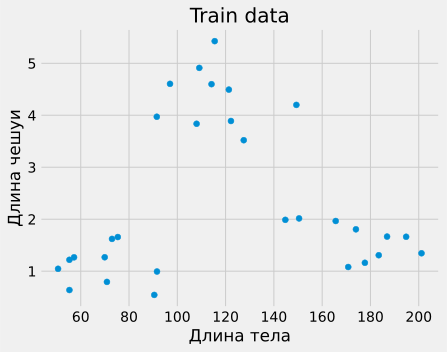

In [ ]:
plt.scatter(train['x'], train['y'])

plt.xlabel('Длина тела')
plt.ylabel('Длина чешуи')

plt.title('Train data')

plt.show()

Прежде чем приступить к кластеризации, отмасштабируем наши данные с помощью уже знакомого нам `MinMaxScaler`:

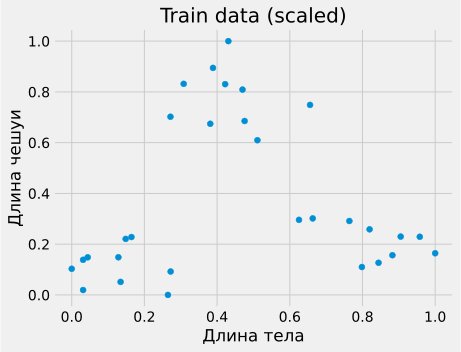

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=['x', 'y'])

plt.scatter(train_scaled['x'], train_scaled['y'])

plt.xlabel('Длина тела')
plt.ylabel('Длина чешуи')

plt.title('Train data (scaled)')

plt.show()

Итак, перейдём к кластеризации. С помощью метода `.fit_predict` можно обучить модель, а затем сразу же получить метки кластеров на входных данных:

In [ ]:
train_labels = model.fit_predict(train_scaled)

print(train_labels)

[2 2 1 1 1 2 0 2 0 1 1 0 0 0 0 0 2 0 2 2 1 0 1 1 2 2 2 0 1 1]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


С помощью атрибута `.cluster_centers_` можно получить получившиеся в результате работы алгоритма центры кластеров. Чтобы изобразить эти центры на плоскости, воспользуемся методом `scaler.inverse_transform`, который преобразует отмасштабированные значения обратно в сырые. Центры на графике пометим красными ромбами. Кроме того, покрасим объекты из разных кластеров в разные цвета для наглядности.

Text(0.5, 1.0, 'Train data')

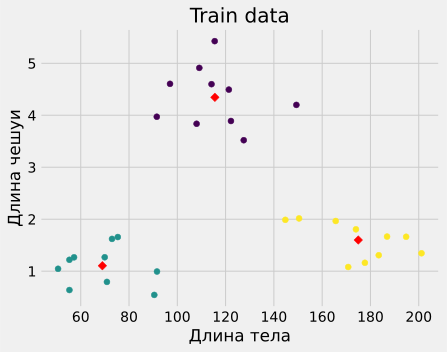

In [ ]:
centers = scaler.inverse_transform(model.cluster_centers_)

plt.scatter(train['x'], train['y'], c=train_labels)
plt.scatter(centers[:, 0], centers[:, 1], marker='D', color='red')

plt.xlabel('Длина тела')
plt.ylabel('Длина чешуи')

plt.title('Train data')

Основная проблема алгоритма k-means в том, что нам нужно заранее знать количество кластеров. Однако, в реальности это не всегда бывает возможно. Количество кластеров можно оценить, используя величину _inertia_. Эта величина равна сумме квадратов расстояний от объектов до центров их кластеров. Чем лучше кластеризация, тем меньше эта величина. Кроме того, она уменьшается с увеличением числа кластеров (она равна 0, если кластеров столько же, сколько объектов), поэтому нужно соблюдать баланс между количеством кластеров, которое нам подходит, и величиной inertia, чтобы число кластеров было разумным.

In [ ]:
model.inertia_

0.5417377477488046

Посчитаем эту величину на наших данных при различном количестве кластеров.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

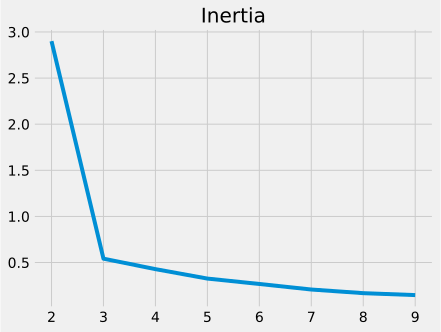

In [ ]:
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(train_scaled)

    temp_inertia = temp_model.inertia_

    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)

plt.title('Inertia')

plt.show()

Мы видим сильное снижение inertia при переходе от 2 к 3 кластерам, а дальше идёт более плавное уменьшение. Это означает, что 3 - адекватное число кластеров. Такой подход называется _методом локтя_.

Теперь перейдём к тестовым данным. Нормализуем их, а затем попробуем отнести их к одному из получившихся кластеров.

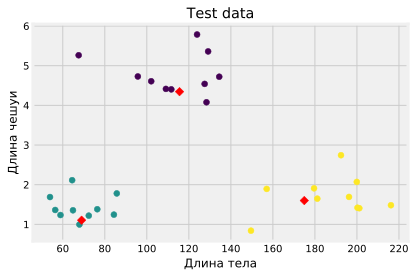

In [ ]:
test_scaled = pd.DataFrame(scaler.transform(test), columns=['x', 'y'])

test_labels = model.predict(test_scaled)

plt.scatter(test['x'], test['y'], c=test_labels)
plt.scatter(centers[:, 0], centers[:, 1], marker='D', color='red')

plt.xlabel('Длина тела')
plt.ylabel('Длина чешуи')

plt.title('Test data')

plt.show()

Как мы видим, каждый объект из тестовых данных вполне оправданно был отнесён к соответствующему кластеру.

